# Multi-label classification using neural networks
## Integrative Engineering, Digital Imaging 20175437 신준섭 **Assignment 9**

## Input Data

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp

file_path = "mnist.csv"

IMG_SZ_ROW, IMG_SZ_COL = 28, 28
TOTAL_IMG_SZ = IMG_SZ_ROW * IMG_SZ_COL

total_image, total_labels = [], []

with open(file_path, "r") as file_handler:
    raw_data = file_handler.readlines();
    for line in raw_data:
        img = line.split(',')
        total_image.append([*map(lambda x: (float(x) / 255.0), img[1:])])
        total_labels.append([int(img[0])])

total_image, total_labels = np.matrix(total_image), np.matrix(total_labels)

train_X, test_X = total_image[:6000,:].transpose(), total_image[6000:,:].transpose()

train_L = (np.eye(10)[total_labels[0:6000].reshape(-1)])[0].transpose()
test_L = (np.eye(10)[total_labels[6000:].reshape(-1)])[0].transpose()

train_X = np.concatenate((train_X, np.ones((1, 6000))))
test_X = np.concatenate((test_X, np.ones((1, 4000))))

## Neural Network

In [76]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

def dev_sigmoid(z):
    return np.multiply(sigmoid(z), (1.0 - sigmoid(z)))

class Network:
    def __init__(self):
        self.U = np.random.normal(0, 1, (196, 784 + 1))
        self.V = np.random.normal(0, 1, (49, 196 + 1))
        self.W = np.random.normal(0, 1, (10, 49 + 1))

    def getLoss(self, X, L):
        assert X.shape[1] == L.shape[1], "number of train data is not equal to label data"
        N = X.shape[1]
        u_ = np.matmul(self.U, X)
        u  = np.concatenate((sigmoid(u_), np.ones((1, N))))
        v_ = np.matmul(self.V, u)
        v  = np.concatenate((sigmoid(v_), np.ones((1, N))))
        w_ = np.matmul(self.W, v)
        w  = sigmoid(w_)
        
        losses = np.multiply(-1.0 * L, np.log(w)) - np.multiply(1.0 - L, np.log(1.0 - w))
        
        return (1.0 / float(N)) * np.sum(losses)

    def getAccuracy(self, X, L):
        assert X.shape[1] == L.shape[1], "number of train data is not equal to label data"
        N = X.shape[1]

        u_ = np.matmul(self.U, X)
        u  = np.concatenate((sigmoid(u_), np.ones((1, N))))
        v_ = np.matmul(self.V, u)
        v  = np.concatenate((sigmoid(v_), np.ones((1, N))))
        w_ = np.matmul(self.W, v)
        w  = sigmoid(np.matmul(self.W, v))

        losses = np.multiply(-1.0 * L, np.log(w)) - np.multiply(1.0 - L, np.log(1.0 - w))

        max_w_indices = np.argmax(w, axis=0)
        max_l_indices = np.argmax(L, axis=0)

        hit, miss = 0, 0

        for i in range(N):
            if max_w_indices[0,i] == max_l_indices[i]:
                hit = hit + 1
            else:
                miss = miss + 1
        
        return float(hit) / (float(hit) + float(miss))

    def forwardPropagation(self, X, L):
        assert X.shape[1] == L.shape[1], "number of train data is not equal to label data"
        N = X.shape[1]

        self.u_ = np.matmul(self.U, X)
        self.u  = np.concatenate((sigmoid(self.u_), np.ones((1, N))))
        self.v_ = np.matmul(self.V, self.u)
        self.v  = np.concatenate((sigmoid(self.v_), np.ones((1, N))))
        self.w_ = np.matmul(self.W, self.v)        
        self.w  = sigmoid(self.w_)
        

        self.loss_mat = np.multiply(-1.0 * L, np.log(self.w)) - np.multiply(1.0 - L, np.log(1.0 - self.w))

        return (1.0 / float(N)) * np.sum(self.loss_mat)

    def backPropagation(self, X, L, lr = 0.01):
        N = X.shape[1]

        dJdw  = np.divide(1.0 - L, 1.0 - self.w) - np.divide(L, self.w)
        dwdw_ = dev_sigmoid(self.w_)
        dw_dW = self.v

        dJdw_ = np.multiply(dJdw, dwdw_)
        dJdW  = np.matmul(dJdw_, dw_dW.transpose())
        self.W = self.W - lr * dJdW

        dw_dv = self.W[:,:-1]
        dvdv_ = dev_sigmoid(self.v_)
        dv_dV = self.u

        dJdv  = np.matmul(dw_dv.transpose(), dJdw_)
        dJdv_ = np.multiply(dJdv, dvdv_)
        dJdV  = np.matmul(dJdv_, dv_dV.transpose())
        self.V = self.V - lr * dJdV

        dv_du = self.V[:,:-1]
        dudu_ = dev_sigmoid(self.u_)
        du_dU = X

        dJdu  = np.matmul(dv_du.transpose(), dJdv_)
        dJdu_ = np.multiply(dJdu, dudu_)
        dJdU  = np.matmul(dJdu_, du_dU.transpose())
        self.U = self.U - lr * dJdU
        

## Training

In [77]:
network = Network()

learning_rate = 0.0001
train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

iterationss = 10

for i in range(iterationss):
    network.forwardPropagation(train_X, train_L)
    network.getLoss(train_X, train_L)

    network.backPropagation(train_X, train_L, learning_rate)

    train_losses.append(network.getLoss(train_X, train_L))
    test_losses.append(network.getLoss(test_X, test_L))

    train_accuracies.append(network.getAccuracy(train_X, train_L))
    test_accuracies.append(network.getAccuracy(test_X, test_L))


## 1. Plot the loss curve

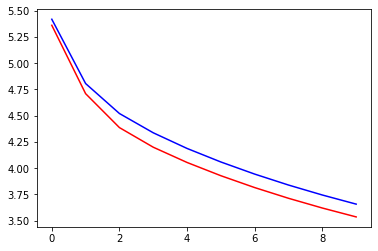

In [78]:
iter_x = list(range(iterationss))

plt.plot(iter_x, train_losses, color='red')
plt.plot(iter_x, test_losses, color='blue')

plt.show()

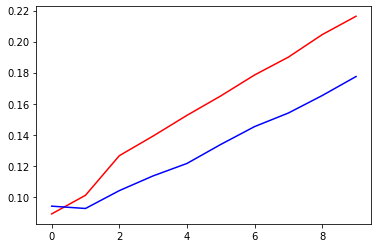

In [79]:
plt.plot(iter_x, train_accuracies, color='red')
plt.plot(iter_x, test_accuracies, color='blue')

plt.show()